<a href="https://colab.research.google.com/github/Leo-Ram/Monitoreo/blob/master/btc7dias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from matplotlib import pyplot as plt

# Download Bitcoin historical data at 1-minute intervals
df = yf.download('BTC-USD', start='2024-02-10', end='2025-03-11', interval='1h')



#btc_data.to_csv('his7dias.csv', index=False)

[*********************100%***********************]  1 of 1 completed


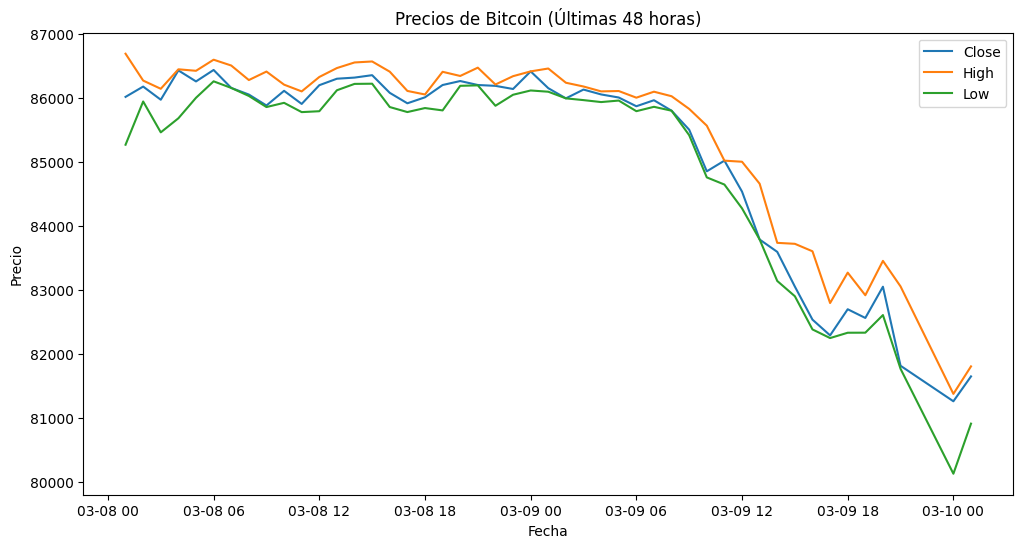

In [15]:
# Filtrar el DataFrame para las últimas 3 horas
last_3_hours = df[df.index >= df.index[-1] - pd.Timedelta(hours=48)] #se calcula la hora actual 48 horas

# Graficar las últimas 3 horas
plt.figure(figsize=(12, 6))
plt.plot(last_3_hours.index, last_3_hours['Close'], label='Close')
plt.plot(last_3_hours.index, last_3_hours['High'], label='High')
plt.plot(last_3_hours.index, last_3_hours['Low'], label='Low')

plt.title('Precios de Bitcoin (Últimas 48 horas)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [16]:
# Cargar tus datos (ejemplo)
data = df[["Close", "High", "Low"]].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length=7*24, pred_length=24):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length+1):
        X.append(data[i:(i+seq_length), :])
        y.append(data[i+seq_length:(i+seq_length+pred_length), 0])  # Predecir "Close"
    return np.array(X), np.array(y)

seq_length = 7*24  # 7 días de datos (asumiendo datos horarios)
pred_length = 24   # Predecir las próximas 24 horas

X, y = create_sequences(scaled_data, seq_length, pred_length)

# Dividir en train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 3)))
model.add(LSTM(100))
model.add(Dense(pred_length))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 37s 148ms/step - loss: 0.0166 - val_loss: 0.0014
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - loss: 6.7463e-04 - val_loss: 0.0024
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - loss: 7.1477e-04 - val_loss: 0.0015
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - loss: 6.4095e-04 - val_loss: 0.0016
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - loss: 6.4034e-04 - val_loss: 0.0013
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 34s 147ms/step - loss: 6.3675e-04 - val_loss: 0.0014
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - loss: 6.0930e-04 - val_loss: 0.0013
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - loss: 6.4087e-04 - val_loss: 0.0017
Epoch 9/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - loss: 6.0006e-04 - val_loss: 0.0012
Epoch 10/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - loss: 5.8910e-04 - val_loss: 0.0013
Epoch 11/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - loss: 6.0658e-04 - val_los

In [17]:
# Predecir las próximas 24 horas
future_predictions = model.predict(last_sequence.reshape(1, seq_length, 3))

# Asegurarte de que future_predictions tenga la forma correcta
future_predictions = future_predictions.reshape(-1, 1)

# Crear un array de ceros con la misma longitud
zeros_array = np.zeros((future_predictions.shape[0], 2))

# Concatenar
concatenated = np.concatenate([future_predictions, zeros_array], axis=1)

# Invertir la normalización
future_predictions = scaler.inverse_transform(concatenated)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


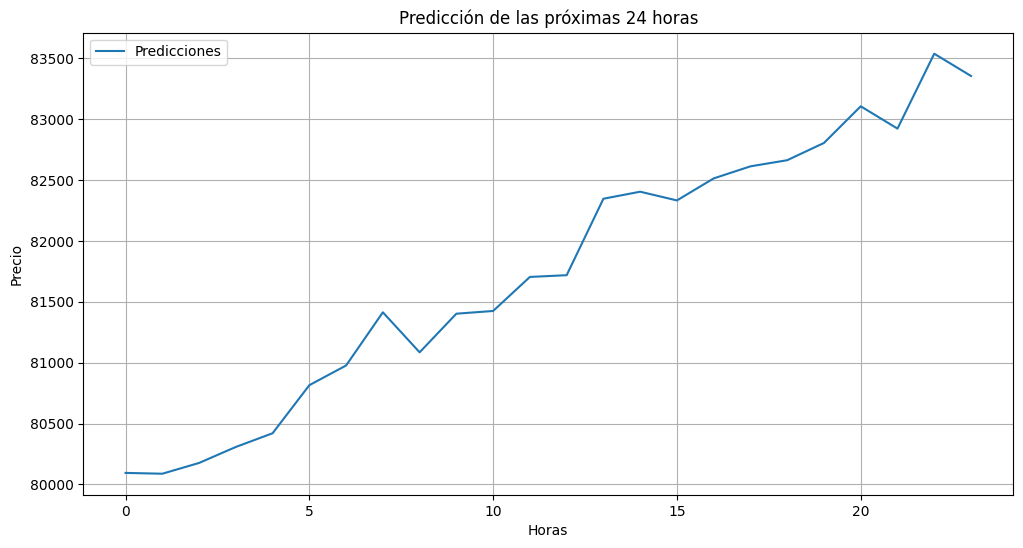

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(future_predictions, label='Predicciones')
plt.title('Predicción de las próximas 24 horas')
plt.xlabel('Horas')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Guardar el modelo completo (arquitectura + pesos + optimizador)
model.save('mi_modelo_entrenado.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
loaded_model = load_model('mi_modelo_entrenado.h5')

# Ahora puedes usar loaded_model para hacer predicciones
# Por ejemplo:
# future_predictions = loaded_model.predict(last_sequence.reshape(1, seq_length, 3))